In [1]:
import matplotlib.pyplot as plt
import numpy as np

#### Problem statement:    
Our forward model for the data is d=Ax+n, where n is Gaussian noise, A is a prefactor, x is the underlying signal. We are interested in inferring A. x follows a standard normal distribution, n follows a Gaussian distribution with mean zero and variance sigma^2.

#### Week 1:   
Questions:
- What is the expression for P(x)? 
- What is the expression for P(d|x,A) (The probability of the data given a realization of x)?
- How do we compute P(A|d)? (Hint: Bayesian theorem and marginalization. how is P(A|d) related to  P(x,d|A)?, How is P(x,d|A) related to P(d|x,A)?)
- Can you find the actual expression for P(A|d)?
(This one is a bit tricky, you need to marginalize over x. To do this, first find the expression for P(x,d|A), then do quadratic completion to bring it into a Gaussian form (wrt to x), then you can do the Gaussian integral) 
- How does PyDelfi compute P(A|d)?

Coding:  
- write a function that generates realizations of 'x'. (for now x, n and d are just scalars)
- write a function that generates realizations of 'n'.
- write a function that calls these two functions to generate data.
- Generate many (N=1000) realizations of the data and plot the distribution.


#### Week 2: 
We now add another parameter to the forward model d = Ax+b+n.   
Questions:
- What is P(A,b|d), what is P(A|d)? (expressions)
- What would a Fisher analysis give you? (A Fisher analysis is when you aproximate P(A,b|d) as a Gaussian, with mean= max_a,b(P(A,b|d) and covariance_ij=partial_i partial_j P(A,b|d), where (i,j) are indices that run through the parameters (a,b))

Coding:
- Run PyDelfi on the problem. How does the result compare to the exact expression?
- Sample the distribution and run a Kernel Density Estimation (KDE) on it. 

#### Week 3:
We now move to higher dimensional data. dim(x)=dim(n)=dim(d)=M. Remember, we have two numbers here: the dimensionality M and the number of realizations N.

Coding:
- Run PyDelfi on our vanilla problem for N<<M, N<M, N=M, N>M, N>>M. Choose M = 10,50. What do you observe?
- Do the same thing, but increase the number of parameters that you want to determine, e.g. make A a diagonal matrix with M entries, and you want to determine each of these entries.
- How does sampling+KDE scale here?



In [2]:
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pydelfi.score as score

In [3]:
def generate_signal(dims=2, n_sample=100, random_seed=None):
    
    np.random.seed(random_seed)
    x = np.random.randn(n_sample,dims)
    return x

def generate_noise(sigma, dims=2, n_sample=100, random_seed=None):
    
    np.random.seed(random_seed)
    n = np.random.randn(n_sample,dims)*sigma
    return n

def generate_data(A, sigma, dims, n_sample, random_seeds=[None,None]):
    
    signal= generate_signal(dims, n_sample, random_seed=random_seeds[0])
    noise = generate_noise(sigma, dims, n_sample, random_seed=random_seeds[1])
    data  = signal+A+noise
    
    return data

In [4]:
# specifications
# this is the dimensionality of the data
dims      = 2
# this is the noise level in our measurement
sigma     = 0.1
# this is the parameter we are interested in inferring from the data
A_0       = np.asarray([-2,2])







In [5]:
data        = generate_data(A_0,sigma,dims,n_sample=1, random_seeds=[568,176])

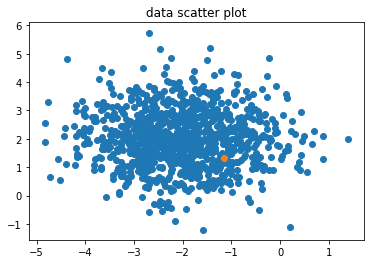

In [6]:
# draw a large data sample to visualize the data distribution
data_sample = generate_data(A_0,sigma,dims,n_sample=1000)
# and plot it
plt.title('data scatter plot')
plt.scatter(data_sample[:,0],data_sample[:,1])
plt.scatter(data[:,0],data[:,1])
plt.show()

In [7]:
plt.hist()

TypeError: hist() missing 1 required positional argument: 'x'

In [8]:
# now we have to create a training sample for pydelfi out of pairs (A, data)
# let's just sample values for A on a grid for now (we can try different sampling methods later)


As = np.linspace(-6,6,400)

training_data = []
training_params = []
for a_0 in As:
    for a_1 in As:
        training_params.append(np.asarray([a_0,a_1]))
        training_data.append(generate_data(training_params[-1],sigma,dims,n_sample=1))
training_params = np.squeeze(np.asarray(training_params))
training_data   = np.squeeze(np.asarray(training_data))

In [9]:
# do we have any preknowledge about the parameter values?
# for now let's assume we now that they are bigger than 0 and smaller than 5
lower = -6
upper = 6
prior = priors.Uniform(np.asarray([lower,lower]), np.asarray([upper,upper]))

In [10]:
# now we need to design our networks
# let's use a gaussian mixture model with one Gaussian and a MAF

# NDEs you wanna train
NDEs =[ndes.MixtureDensityNetwork(n_parameters=len(A_0), n_data=dims, n_components=1, n_hidden=[2,2], activations=[tf.tanh,tf.tanh], index=0)]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
DelfiEnsemble = delfi.Delfi(np.squeeze(data), prior, NDEs, 
                            Finv = None, 
                            theta_fiducial = None, 
                            param_limits = [np.asarray([lower,lower]), np.asarray([upper,upper])],
                            param_names = [r'a_0', r'a_1'], 
                            input_normalization=None,restore=False)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().





In [12]:
training_data.shape

(160000, 2)

In [13]:
DelfiEnsemble.load_simulations(training_data,training_params)

In [14]:
DelfiEnsemble.train_ndes()

INFO:tensorflow:Restoring parameters from graph_checkpoint


In [15]:
posterior_samples = DelfiEnsemble.emcee_sample()

Removed no burn in


/home/nessa/miniconda3/envs/MnuLFI/lib/python3.7/site-packages/pydelfi/delfi.py:626: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


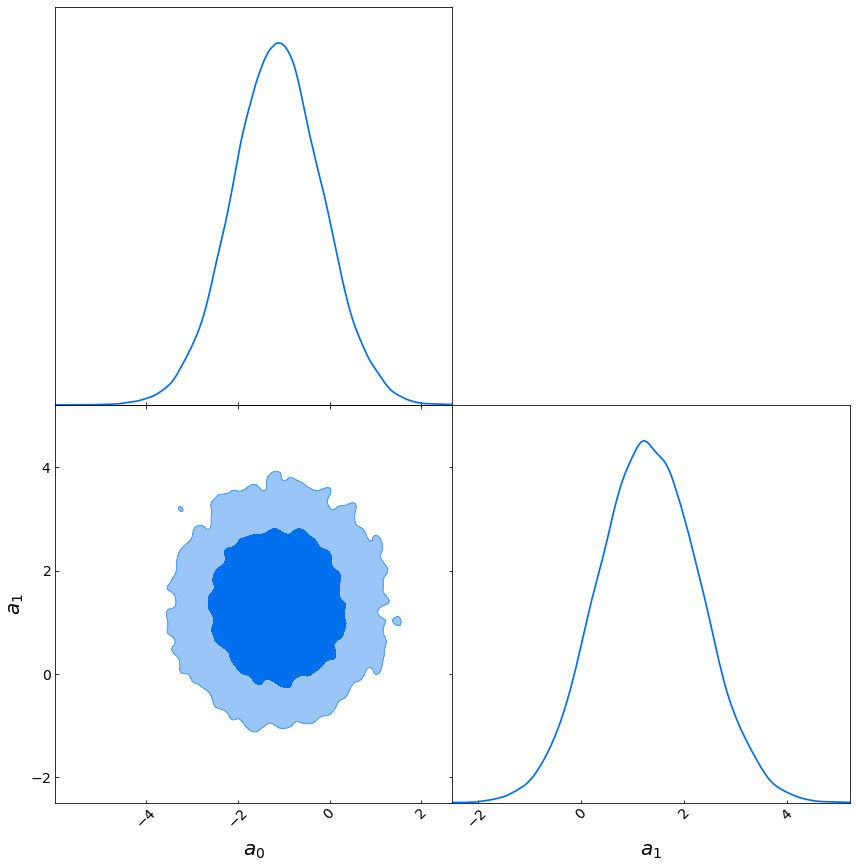

In [16]:
DelfiEnsemble.triangle_plot([posterior_samples])